This is the 8th simple toy model to adapt the LLH NN from Ice Cube to tracker geometry. We're using the actual tracker geometry now (32 layers with 32 straws). The straws are 5mm in diameter, and tracks are curved. Each bin registers hit/no hit with 100% efficiency, and the distance from the straw center as a Gaussian random variable. Instead of using (z,p,phi), we are now using (x,z,p) and assume that phi=0 always.

Training on large parameter range with 1e6 samples.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

from scipy import stats
from scipy import constants
from scipy.special import erf
import types
from scipy.optimize import minimize, Bounds

from LLH_NN_utils import *

In [3]:
UView = {

        'x': [-12.696, -12.696, -12.696, -12.696, -12.696, -12.696, -12.696, -12.696, -12.696, -12.696, -12.696, -12.696, -12.696, -12.696, -12.696, -12.696, -12.696, -12.696, -12.696, -12.696, -12.696, -12.696, -12.696, -12.696, -12.696, -12.696, -12.696, -12.696, -12.696, -12.696, -12.696, -12.696, -7.5, -7.5, -7.5, -7.5, -7.5, -7.5, -7.5, -7.5, -7.5, -7.5, -7.5, -7.5, -7.5, -7.5, -7.5, -7.5, -7.5, -7.5, -7.5, -7.5, -7.5, -7.5, -7.5, -7.5, -7.5, -7.5, -7.5, -7.5, -7.5, -7.5, -7.5, -7.5, 121.6674, 121.6677, 121.6679, 121.6671, 121.6673, 121.6677, 121.667, 121.667, 121.667, 121.667, 121.667, 121.667, 121.667, 121.667, 121.667, 121.667, 121.667, 121.667, 121.667, 121.667, 121.667, 121.667, 121.667, 121.667, 121.667, 121.667, 121.667, 121.667, 121.667, 121.667, 121.667, 121.667, 126.8635, 126.8638, 126.863, 126.8632, 126.8634, 126.8637, 126.863, 126.863, 126.863, 126.863, 126.863, 126.863, 126.863, 126.863, 126.863, 126.863, 126.863, 126.863, 126.863, 126.863, 126.863, 126.863, 126.863, 126.863, 126.863, 126.863, 126.863, 126.863, 126.863, 126.863, 126.863, 126.863, 256.021, 256.021, 256.021, 256.021, 256.021, 256.021, 256.021, 256.021, 256.021, 256.021, 256.021, 256.021, 256.021, 256.021, 256.021, 256.021, 256.021, 256.021, 256.021, 256.021, 256.021, 256.021, 256.021, 256.021, 256.021, 256.021, 256.021, 256.021, 256.021, 256.021, 256.021, 256.021, 261.217, 261.217, 261.217, 261.217, 261.217, 261.217, 261.217, 261.217, 261.217, 261.217, 261.217, 261.217, 261.217, 261.217, 261.217, 261.217, 261.217, 261.217, 261.217, 261.217, 261.217, 261.217, 261.217, 261.217, 261.217, 261.217, 261.217, 261.217, 261.217, 261.217, 261.217, 261.217, 390.375, 390.375, 390.375, 390.375, 390.375, 390.375, 390.375, 390.375, 390.375, 390.375, 390.375, 390.375, 390.375, 390.375, 390.375, 390.375, 390.375, 390.375, 390.375, 390.375, 390.375, 390.375, 390.375, 390.375, 390.375, 390.375, 390.375, 390.375, 390.375, 390.375, 390.375, 390.375, 395.571, 395.571, 395.571, 395.571, 395.571, 395.571, 395.571, 395.571, 395.571, 395.571, 395.571, 395.571, 395.571, 395.571, 395.571, 395.571, 395.571, 395.571, 395.571, 395.571, 395.571, 395.571, 395.571, 395.571, 395.571, 395.571, 395.571, 395.571, 395.571, 395.571, 395.571, 395.571, 524.725, 524.725, 524.725, 524.725, 524.725, 524.725, 524.725, 524.725, 524.725, 524.725, 524.725, 524.725, 524.725, 524.725, 524.725, 524.725, 524.725, 524.725, 524.725, 524.725, 524.725, 524.725, 524.725, 524.725, 524.725, 524.725, 524.725, 524.725, 524.725, 524.725, 524.725, 524.725, 529.921, 529.921, 529.921, 529.921, 529.921, 529.921, 529.921, 529.921, 529.921, 529.921, 529.921, 529.921, 529.921, 529.921, 529.921, 529.921, 529.921, 529.921, 529.921, 529.921, 529.921, 529.921, 529.921, 529.921, 529.921, 529.921, 529.921, 529.921, 529.921, 529.921, 529.921, 529.921, 659.065,  659.065, 659.065, 659.065, 659.065, 659.065, 659.065, 659.065, 659.065, 659.065, 659.065, 659.065, 659.065, 659.065, 659.065, 659.065, 659.065, 659.065, 659.065, 659.065, 659.065, 659.065, 659.065, 659.065, 659.065, 659.065, 659.065, 659.065, 659.065, 659.065, 659.065, 659.065, 664.261, 664.261, 664.261, 664.261, 664.261, 664.261, 664.261, 664.261, 664.261, 664.261, 664.261, 664.261, 664.261, 664.261, 664.261, 664.261, 664.261, 664.261, 664.261, 664.261, 664.261, 664.261, 664.261, 664.261, 664.261, 664.261, 664.261, 664.261, 664.261, 664.261, 664.261, 664.261, 793.407, 793.407, 793.407, 793.407, 793.407, 793.407, 793.407, 793.407, 793.407, 793.407, 793.407, 793.407, 793.407, 793.407, 793.407, 793.407, 793.407, 793.407, 793.407, 793.407, 793.407, 793.407, 793.407, 793.407, 793.407, 793.407, 793.407, 793.407, 793.407, 793.407, 793.407, 793.407, 798.603, 798.603, 798.603, 798.603, 798.603, 798.603, 798.603, 798.603, 798.603, 798.603, 798.603, 798.603, 798.603, 798.603, 798.603, 798.603, 798.603, 798.603, 798.603, 798.603, 798.603, 798.603, 798.603, 798.603, 798.603, 798.603, 798.603, 798.603, 798.603, 798.603, 798.603, 798.603, 927.737, 927.737, 927.737, 927.737, 927.737, 927.737, 927.737, 927.737, 927.737, 927.737, 927.737, 927.737, 927.737, 927.737, 927.737, 927.737, 927.737, 927.737, 927.737, 927.737, 927.737, 927.737, 927.737, 927.737, 927.737, 927.737, 927.737, 927.737, 927.737, 927.737, 927.737, 927.737, 932.933, 932.933, 932.933, 932.933, 932.933, 932.933, 932.933, 932.933, 932.933, 932.933, 932.933, 932.933, 932.933, 932.933, 932.933, 932.933, 932.933, 932.933, 932.933, 932.933, 932.933, 932.933, 932.933, 932.933, 932.933, 932.933, 932.933, 932.933, 932.933, 932.933, 932.933, 932.933],

        'y': [-64.3105, -58.2588, -52.207, -46.1552, -40.1034, -34.0517, -27.9999, -21.9481, -15.8963, -9.84457, -3.7928, 2.25898, 8.31075, 14.3625, 20.4143, 26.4661, 32.5178, 38.5696, 44.6214, 50.6732, 56.7249, 62.7767, 68.8285, 74.8803, 80.932, 86.9838, 93.0356, 99.0874, 105.139, 111.191, 117.243, 123.294, -61.2846, -55.2329, -49.1811, -43.1293, -37.0775, -31.0258, -24.974, -18.9222, -12.8704, -6.81867, -0.766897, 5.28488, 11.3367, 17.3884, 23.4402, 29.492, 35.5437, 41.5955, 47.6473, 53.6991, 59.7508, 65.8026, 71.8544, 77.9062, 83.9579, 90.0097, 96.0615, 102.113, 108.165, 114.217, 120.269, 126.32, -34.5014, -28.4497, -22.3979, -16.3461, -10.2943, -4.24257, 1.80921, 7.86098, 13.9128, 19.9645, 26.0163, 32.0681, 38.1198, 44.1716, 50.2234, 56.2752, 62.3269, 68.3787, 74.4305, 80.4823, 86.534, 92.5858, 98.6376, 104.689, 110.741, 116.793, 122.845, 128.896, 134.948, 141, 147.052, 153.104, -31.4755, -25.4238, -19.372, -13.3202, -7.26844, -1.21667, 4.83511, 10.8869, 16.9387, 22.9904, 29.0422, 35.094, 41.1457, 47.1975, 53.2493, 59.3011, 65.3528, 71.4046, 77.4564, 83.5082, 89.5599, 95.6117, 101.663, 107.715, 113.767, 119.819, 125.871, 131.922, 137.974, 144.026, 150.078, 156.129, -7.35165, -1.29987, 4.7519, 10.8037, 16.8554, 22.9072, 28.959, 35.0108, 41.0625, 47.1143, 53.1661, 59.2179, 65.2696, 71.3214, 77.3732, 83.425, 89.4767, 95.5285, 101.58, 107.632, 113.684, 119.736, 125.787, 131.839, 137.891, 143.943, 149.994, 156.046, 162.098, 168.15, 174.202, 180.253, -4.32575, 1.72603, 7.7778, 13.8296, 19.8813, 25.9331, 31.9849, 38.0367, 44.0884, 50.1402, 56.192, 62.2438, 68.2955, 74.3473, 80.3991, 86.4509, 92.5026, 98.5544, 104.606, 110.658, 116.71, 122.762, 128.813, 134.865, 140.917, 146.969, 153.02, 159.072, 165.124, 171.176, 177.227, 183.279, 17.1099, 23.1617, 29.2135, 35.2652, 41.317, 47.3688, 53.4206, 59.4723, 65.5241, 71.5759, 77.6277, 83.6794, 89.7312, 95.783, 101.835, 107.887, 113.938, 119.99, 126.042, 132.094, 138.145, 144.197, 150.249, 156.301, 162.352, 168.404, 174.456, 180.508, 186.56, 192.611, 198.663, 204.715, 20.1358, 26.1876, 32.2394, 38.2911, 44.3429, 50.3947, 56.4465, 62.4982, 68.55, 74.6018, 80.6536, 86.7053, 92.7571, 98.8089, 104.861, 110.912, 116.964, 123.016, 129.068, 135.12, 141.171, 147.223, 153.275, 159.327, 165.378, 171.43, 177.482, 183.534, 189.585, 195.637, 201.689, 207.741, 38.8201, 44.8719, 50.9237, 56.9754, 63.0272, 69.079, 75.1308, 81.1825, 87.2343, 93.2861, 99.3379, 105.39, 111.441, 117.493, 123.545, 129.597, 135.649, 141.7, 147.752, 153.804, 159.856, 165.907, 171.959, 178.011, 184.063, 190.114, 196.166, 202.218, 208.27, 214.322, 220.373, 226.425, 41.846, 47.8978, 53.9496, 60.0013, 66.0531, 72.1049, 78.1567, 84.2084, 90.2602, 96.312, 102.364, 108.416, 114.467, 120.519, 126.571, 132.623, 138.674, 144.726, 150.778, 156.83, 162.881, 168.933, 174.985, 181.037, 187.089, 193.14, 199.192, 205.244, 211.296, 217.347, 223.399, 229.451, 57.9122, 63.964, 70.0158, 76.0675, 82.1193, 88.1711, 94.2229, 100.275, 106.326, 112.378, 118.43, 124.482, 130.534, 136.585, 142.637, 148.689, 154.741, 160.792, 166.844, 172.896, 178.948, 184.999, 191.051, 197.103, 203.155, 209.207, 215.258, 221.31, 227.362, 233.414, 239.465, 245.517, 60.9381, 66.9899, 73.0417, 79.0934, 85.1452, 91.197, 97.2488, 103.301, 109.352, 115.404, 121.456, 127.508, 133.559, 139.611, 145.663, 151.715, 157.767, 163.818, 169.87, 175.922, 181.974, 188.025, 194.077, 200.129, 206.181, 212.232, 218.284, 224.336, 230.388, 236.44, 242.491, 248.543, 74.3793, 80.4311, 86.4828, 92.5346, 98.5864, 104.638, 110.69, 116.742, 122.793, 128.845, 134.897, 140.949, 147.001, 153.052, 159.104, 165.156, 171.208, 177.259, 183.311, 189.363, 195.415, 201.467, 207.518, 213.57, 219.622, 225.674, 231.725, 237.777, 243.829, 249.881, 255.932, 261.984, 77.4052, 83.457, 89.5087, 95.5605, 101.612, 107.664, 113.716, 119.768, 125.819, 131.871, 137.923, 143.975, 150.026, 156.078, 162.13, 168.182, 174.234, 180.285, 186.337, 192.389, 198.441, 204.492, 210.544, 216.596, 222.648, 228.7, 234.751, 240.803, 246.855, 252.907, 258.958, 265.01, 88.2379, 94.2896, 100.341, 106.393, 112.445, 118.497, 124.549, 130.6, 136.652, 142.704, 148.756, 154.807, 160.859, 166.911, 172.963, 179.014, 185.066, 191.118, 197.17, 203.222, 209.273, 215.325, 221.377, 227.429, 233.48, 239.532, 245.584, 251.636, 257.688, 263.739, 269.791, 275.843, 91.2638, 97.3155, 103.367, 109.419, 115.471, 121.523, 127.574, 133.626, 139.678, 145.73, 151.782, 157.833, 163.885, 169.937, 175.989, 182.04, 188.092, 194.144, 200.196, 206.247, 212.299, 218.351, 224.403, 230.455, 236.506, 242.558, 248.61, 254.662, 260.713, 266.765, 272.817, 278.869]
    
}

VView = {

        'x': [7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 12.696, 12.696, 12.696, 12.696, 12.696, 12.696, 12.696, 12.696, 12.696, 12.696, 12.696, 12.696, 12.696, 12.696, 12.696, 12.696, 12.696, 12.696, 12.696, 12.696, 12.696, 12.696, 12.696, 12.696, 12.696, 12.696, 12.696, 12.696, 12.696, 12.696, 12.696, 12.696, 141.863, 141.863, 141.863, 141.863, 141.863, 141.863, 141.863, 141.863, 141.863, 141.863, 141.863, 141.863, 141.863, 141.863, 141.863, 141.863, 141.863, 141.863, 141.863, 141.863, 141.863, 141.863, 141.863, 141.863, 141.863, 141.863, 141.863, 141.863, 141.863, 141.863, 141.863, 141.863, 147.059, 147.059, 147.059, 147.059, 147.059, 147.059, 147.059, 147.059, 147.059, 147.059, 147.059, 147.059, 147.059, 147.059, 147.059, 147.059, 147.059, 147.059, 147.059, 147.059, 147.059, 147.059, 147.059, 147.059, 147.059, 147.059, 147.059, 147.059, 147.059, 147.059, 147.059, 147.059, 276.217, 276.217, 276.217, 276.217, 276.217, 276.217, 276.217, 276.217, 276.217, 276.217, 276.217, 276.217, 276.217, 276.217, 276.217, 276.217, 276.217, 276.217, 276.217, 276.217, 276.217, 276.217, 276.217, 276.217, 276.217, 276.217, 276.217, 276.217, 276.217, 276.217, 276.217, 276.217, 281.413, 281.413, 281.413, 281.413, 281.413, 281.413, 281.413, 281.413, 281.413, 281.413, 281.413, 281.413, 281.413, 281.413, 281.413, 281.413, 281.413, 281.413, 281.413, 281.413, 281.413, 281.413, 281.413, 281.413, 281.413, 281.413, 281.413, 281.413, 281.413, 281.413, 281.413, 281.413, 410.571, 410.571, 410.571, 410.571, 410.571, 410.571, 410.571, 410.571, 410.571, 410.571, 410.571, 410.571, 410.571, 410.571, 410.571, 410.571, 410.571, 410.571, 410.571, 410.571, 410.571, 410.571, 410.571, 410.571, 410.571, 410.571, 410.571, 410.571, 410.571, 410.571, 410.571, 410.571, 415.767, 415.767, 415.767, 415.767, 415.767, 415.767, 415.767, 415.767, 415.767, 415.767, 415.767, 415.767, 415.767, 415.767, 415.767, 415.767, 415.767, 415.767, 415.767, 415.767, 415.767, 415.767, 415.767, 415.767, 415.767, 415.767, 415.767, 415.767, 415.767, 415.767, 415.767, 415.767, 544.921, 544.921, 544.921, 544.921, 544.921, 544.921, 544.921, 544.921, 544.921, 544.921, 544.921, 544.921, 544.921, 544.921, 544.921, 544.921, 544.921, 544.921, 544.921, 544.921, 544.921, 544.921, 544.921, 544.921, 544.921, 544.921, 544.921, 544.921, 544.921, 544.921, 544.921, 544.921, 550.117, 550.117, 550.117, 550.117, 550.117, 550.117, 550.117, 550.117, 550.117, 550.117, 550.117, 550.117, 550.117, 550.117, 550.117, 550.117, 550.117, 550.117, 550.117, 550.117, 550.117, 550.117, 550.117, 550.117, 550.117, 550.117, 550.117, 550.117, 550.117, 550.117, 550.117, 550.117, 679.261, 679.261, 679.261, 679.261, 679.261, 679.261, 679.261, 679.261, 679.261, 679.261, 679.261, 679.261, 679.261, 679.261, 679.261, 679.261, 679.261, 679.261, 679.261, 679.261, 679.261, 679.261, 679.261, 679.261, 679.261, 679.261, 679.261, 679.261, 679.261, 679.261, 679.261, 679.261, 684.457, 684.457, 684.457, 684.457, 684.457, 684.457, 684.457, 684.457, 684.457, 684.457, 684.457, 684.457, 684.457, 684.457, 684.457, 684.457, 684.457, 684.457, 684.457, 684.457, 684.457, 684.457, 684.457, 684.457, 684.457, 684.457, 684.457, 684.457, 684.457, 684.457, 684.457, 684.457, 813.603, 813.603, 813.603, 813.603, 813.603, 813.603, 813.603, 813.603, 813.603, 813.603, 813.603, 813.603, 813.603, 813.603, 813.603, 813.603, 813.603, 813.603, 813.603, 813.603, 813.603, 813.603, 813.603, 813.603, 813.603, 813.603, 813.603, 813.603, 813.603, 813.603, 813.603, 813.603, 818.799, 818.799, 818.799, 818.799, 818.799, 818.799, 818.799, 818.799, 818.799, 818.799, 818.799, 818.799, 818.799, 818.799, 818.799, 818.799, 818.799, 818.799, 818.799, 818.799, 818.799, 818.799, 818.799, 818.799, 818.799, 818.799, 818.799, 818.799, 818.799, 818.799, 818.799, 818.799, 947.933, 947.933, 947.933, 947.933, 947.933, 947.933, 947.933, 947.933, 947.933, 947.933, 947.933, 947.933, 947.933, 947.933, 947.933, 947.933, 947.933, 947.933, 947.933, 947.933, 947.933, 947.933, 947.933, 947.933, 947.933, 947.933, 947.933, 947.933, 947.933, 947.933, 947.933, 947.933, 953.129, 953.129, 953.129, 953.129, 953.129, 953.129, 953.129, 953.129, 953.129, 953.129, 953.129, 953.129, 953.129, 953.129, 953.129, 953.129, 953.129, 953.129, 953.129, 953.129, 953.129, 953.129, 953.129, 953.129, 953.129, 953.129, 953.129, 953.129, 953.129, 953.129, 953.129, 953.129],

        'y': [-60.9556, -54.9038, -48.852, -42.8002, -36.7485, -30.6967, -24.6449, -18.5931, -12.5414, -6.4896, -0.437828, 5.61395, 11.6657, 17.7175, 23.7693, 29.821, 35.8728, 41.9246, 47.9764, 54.0281, 60.0799, 66.1317, 72.1835, 78.2352, 84.287, 90.3388, 96.3906, 102.442, 108.494, 114.546, 120.598, 126.649, -63.9815, -57.9297, -51.8779, -45.8261, -39.7744, -33.7226, -27.6708, -21.619, -15.5673, -9.5155, -3.46373, 2.58805, 8.63982, 14.6916, 20.7434, 26.7951, 32.8469, 38.8987, 44.9505, 51.0022, 57.054, 63.1058, 69.1576, 75.2093, 81.2611, 87.3129, 93.3647, 99.4164, 105.468, 111.52, 117.572, 123.624, -31.1465, -25.0947, -19.0429, -12.9911, -6.93937, -0.887599, 5.16417, 11.2159, 17.2677, 23.3195, 29.3713, 35.423, 41.4748, 47.5266, 53.5784, 59.6301, 65.6819, 71.7337, 77.7855, 83.8372, 89.889, 95.9408, 101.993, 108.044, 114.096, 120.148, 126.2, 132.251, 138.303, 144.355, 150.407, 156.459, -34.1724, -28.1206, -22.0688, -16.017, -9.96527, -3.9135, 2.13827, 8.19005, 14.2418, 20.2936, 26.3454, 32.3971, 38.4489, 44.5007, 50.5525, 56.6042, 62.656, 68.7078, 74.7596, 80.8113, 86.8631, 92.9149, 98.9667, 105.018, 111.07, 117.122, 123.174, 129.226, 135.277, 141.329, 147.381, 153.433, -3.99668, 2.05509, 8.10687, 14.1586, 20.2104, 26.2622, 32.314, 38.3657, 44.4175, 50.4693, 56.5211, 62.5728, 68.6246, 74.6764, 80.7282, 86.7799, 92.8317, 98.8835, 104.935, 110.987, 117.039, 123.091, 129.142, 135.194, 141.246, 147.298, 153.349, 159.401, 165.453, 171.505, 177.557, 183.608, -7.02258, -0.970805, 5.08097, 11.1327, 17.1845, 23.2363, 29.2881, 35.3398, 41.3916, 47.4434, 53.4952, 59.5469, 65.5987, 71.6505, 77.7023, 83.754, 89.8058, 95.8576, 101.909, 107.961, 114.013, 120.065, 126.116, 132.168, 138.22, 144.272, 150.324, 156.375, 162.427, 168.479, 174.531, 180.582, 20.4649, 26.5167, 32.5684, 38.6202, 44.672, 50.7238, 56.7755, 62.8273, 68.8791, 74.9309, 80.9826, 87.0344, 93.0862, 99.138, 105.19, 111.242, 117.293, 123.345, 129.397, 135.449, 141.5, 147.552, 153.604, 159.656, 165.707, 171.759, 177.811, 183.863, 189.915, 195.966, 202.018, 208.07, 17.439, 23.4908, 29.5425, 35.5943, 41.6461, 47.6979, 53.7496, 59.8014, 65.8532, 71.905, 77.9567, 84.0085, 90.0603, 96.1121, 102.164, 108.216, 114.267, 120.319, 126.371, 132.423, 138.474, 144.526, 150.578, 156.63, 162.682, 168.733, 174.785, 180.837, 186.889, 192.94, 198.992, 205.044, 42.1751, 48.2269, 54.2786, 60.3304, 66.3822, 72.434, 78.4857, 84.5375, 90.5893, 96.6411, 102.693, 108.745, 114.796, 120.848, 126.9, 132.952, 139.003, 145.055, 151.107, 157.159, 163.211, 169.262, 175.314, 181.366, 187.418, 193.469, 199.521, 205.573, 211.625, 217.677, 223.728, 229.78, 39.1492, 45.201, 51.2527, 57.3045, 63.3563, 69.4081, 75.4598, 81.5116, 87.5634, 93.6152, 99.6669, 105.719, 111.77, 117.822, 123.874, 129.926, 135.978, 142.029, 148.081, 154.133, 160.185, 166.236, 172.288, 178.34, 184.392, 190.444, 196.495, 202.547, 208.599, 214.651, 220.702, 226.754, 61.2672, 67.319, 73.3707, 79.4225, 85.4743, 91.5261, 97.5778, 103.63, 109.681, 115.733, 121.785, 127.837, 133.888, 139.94, 145.992, 152.044, 158.096, 164.147, 170.199, 176.251, 182.303, 188.354, 194.406, 200.458, 206.51, 212.562, 218.613, 224.665, 230.717, 236.769, 242.82, 248.872, 58.2413, 64.2931, 70.3448, 76.3966, 82.4484, 88.5002, 94.5519, 100.604, 106.655, 112.707, 118.759, 124.811, 130.863, 136.914, 142.966, 149.018, 155.07, 161.121, 167.173, 173.225, 179.277, 185.329, 191.38, 197.432, 203.484, 209.536, 215.587, 221.639, 227.691, 233.743, 239.795, 245.846, 77.7342, 83.786, 89.8378, 95.8896, 101.941, 107.993, 114.045, 120.097, 126.148, 132.2, 138.252, 144.304, 150.356, 156.407, 162.459, 168.511, 174.563, 180.614, 186.666, 192.718, 198.77, 204.821, 210.873, 216.925, 222.977, 229.029, 235.08, 241.132, 247.184, 253.236, 259.287, 265.339, 74.7083, 80.7601, 86.8119, 92.8637, 98.9154, 104.967, 111.019, 117.071, 123.123, 129.174, 135.226, 141.278, 147.33, 153.381, 159.433, 165.485, 171.537, 177.589, 183.64, 189.692, 195.744, 201.796, 207.847, 213.899, 219.951, 226.003, 232.054, 238.106, 244.158, 250.21, 256.262, 262.31, 91.5928, 97.6446, 103.696, 109.748, 115.8, 121.852, 127.903, 133.955, 140.007, 146.059, 152.111, 158.162, 164.214, 170.266, 176.318, 182.369, 188.421, 194.473, 200.525, 206.577, 212.628, 218.68, 224.732, 230.784, 236.835, 242.887, 248.939, 254.991, 261.043, 267.094, 273.146, 279.198, 88.5669, 94.6187, 100.67, 106.722, 112.774, 118.826, 124.878, 130.929, 136.981, 143.033, 149.085, 155.136, 161.188, 167.24, 173.292, 179.344, 185.395, 191.447, 197.499, 203.551, 209.602, 215.654, 221.706, 227.758, 233.81, 239.861, 245.913, 251.965, 258.017, 264.068, 270.12, 276.172]
}

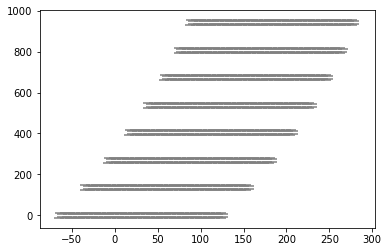

In [9]:
plt.scatter(UView['y'],UView['x'],marker='_',s=100,color='grey')
plt.scatter(VView['y'],VView['x'],marker='_',s=100,color='grey')
plt.show()

##TODO flip around so it's left of ring, make into det_zs and det_xs

In [2]:
#layers at fixed z, giving x position
#source has x,z,pz
# B=1.45
det_zs = np.ones((8,4)) ##TODO
    
N_bins = 32
N_det = len(det_zs)

#det_xs = #centers of straws

### Tracker toy model

Muon decaying at (x,z), producing positron with momentum p in z-direction. $\vec{B} = B\hat{y}$

Since the Lorentz force only acts perpendicular to the direction of motion, $|v|$ and $\gamma$ don't change, and the time derivative is simply
$\frac{d\vec{v}}{dt} = \frac{q}{\gamma m} (\vec{v} \times \vec{B}) = \frac{qB}{\gamma m} (v_x \hat{z} - v_z\hat{x})$

$p_x = p\sin(\frac{qB}{\gamma m} t)$<br/>
$p_z = p\cos(\frac{qB}{\gamma m} t)$

$x = \int_0^T v_x dt = -\frac{\gamma m}{qB} |v| (\cos(\frac{qB}{\gamma m} T) - \frac{v_z(0)}{|v|})$<br/>
$z = \int_0^T v_z dt = \frac{\gamma m}{qB} |v| (\sin(\frac{qB}{\gamma m} T) - \frac{v_x(0)}{|v|})$

$z$ is fixed, so<br/>
$T = \frac{\gamma m}{qB}\arcsin(\frac{qBz +\gamma mv_x(0)}{\gamma m |v|})$

$x = \frac{\gamma m v_z(0)}{qB} - \frac{\gamma m|v|}{qB}\cos(\arcsin(\frac{qBz +\gamma mv_x(0)}{\gamma m |v|})) = \frac{\gamma m v_z(0)}{qB} - \frac{\gamma m|v|}{qB}\sqrt{1 - (\frac{qBz +\gamma mv_x(0)}{\gamma m |v|})^2} = \frac{\gamma m v_z(0)}{qB} - \frac{1}{qB}\sqrt{\gamma^2m^2|v|^2 - (qBz +\gamma mv_x(0))^2}$<br/>
$x = \frac{\gamma m v_z(0)}{qB} - \frac{1}{qB}\sqrt{\gamma^2m^2v_z^2(0) - q^2B^2z^2 -2qBz\gamma mv_x(0)} = \frac{p_z(0)}{qB} - \frac{1}{qB}\sqrt{p_z^2(0) - q^2B^2z^2 -2qBzp_x(0)}$

Change to use $|p|(0) = p$ and initial angle $\phi = 0$ (from the z-axis):<br/>
$x = \frac{p}{qB} - \frac{1}{qB}\sqrt{p^2 - q^2B^2z^2} + x(0) = \frac{p}{qB}(1 - \sqrt{1 - \frac{q^2B^2z^2}{p^2}}) + x(0)$

In [3]:
#leave out e in momentum calc, and q's above

c = constants.c
#e = constants.e
B = 1.45

def calc_x(x,z,p):
    # p is in GeV -> *1e9/c
    p = p*1e9/c
    
    sq = p**2 - B**2*z**2
    #take square root where possible
    sq[sq>=0] = np.sqrt(sq[sq>=0])
    
    res = (p - sq)/B + x
    res[sq<0] = -1

    return res

#example event x_toy,z_toy,p_toy
toy=[1e-3,-0.73,1.9] #this produces hits in almost every layer
#toy=[-1e-2,-0.64,2.3] #this is a flat event, leaving top layers w/o hits
x_toy, z_toy, p_toy = toy

#for Gaussian
sigma = 1e-4

d_hit = lambda x: stats.truncnorm(-x/sigma, np.inf, loc=x, scale=sigma)

In [4]:
##TODO update from here (compare v4)

def generate_event(x, z, p):
#def generate_event(z,p,phi):
    '''
    generates event
    
    Parameters:
    
    z : float
        Vertex position
    p : float
        Initial momentum
    phi : float
        Initial angle (with z-axis)
        
    Returns:
    
    xs : numpy array
        observed x-position per detector
    '''
    
    hits = np.zeros((N_bins,N_det))
    dist = det_zs-z
    x_exp = calc_x(x,dist,p)
    #x_exp = calc_x(dist,p,phi)
    for j in range(N_det):
        #check if x_exp < or > than end of detector
        if x_exp[j] < -2.5e-3 or x_exp[j] > det_xs[j,-1]+2.5e-3:
            continue
        
        #figure out which bin it would hit
        i = (np.abs(det_xs[j] - x_exp[j])).argmin()
        d = np.abs(x_exp[j]-det_xs[j,i])
        
        if d <= 2.5e-3:
            #add distance info from center of bin - Gaussian distribution, cut off at outer radius (both sides)
            #t = np.random.normal(loc=d,scale=sigma)
            #if t<0: t = 0
            #elif t>2.5e-3: t = 2.5e-3
            t = stats.truncnorm(-d/3e-4, np.inf, loc=d, scale=sigma).rvs()
            if t>2.5e-3: t = 2.5e-3
            #t = stats.truncnorm(-d/3e-4, (2.5e-3 - d)/3e-4, loc=d, scale=3e-4).rvs()
            hits[i,j] = t
    return hits

#toy MC
def MC_events(N_events, xlims=(-2.5e-2,2.5e-2), zlims=(-1, -0.5), plims=(0.5,3.5),verbose_lvl = 0):
#def MC_events(N_events, zlims=(-1, -0.001), plims=(1.5,3),phi_lims=(0,np.pi/8)):
    '''
    sample source parameters from uniform distribution of x, p, and phi #isn't really uniform dist
    and generate events using those.
    N_events : int
        number of desired events
    *_lims : tuple
        lower and upper bount of the uniform to sample from
        
    Returns:
    events : list of generated events
    truth : true parameters
    '''

    # truth array z,p,phi
    # p is in GeV -> *1e9/c
    
    #check if particle produces at least 5 hits (3 layers)
    
    x = []
    z = []
    p = []
    #phi = []
    events = []
    
    while len(events)<N_events:
        n_evs = N_events-len(events)
        if verbose_lvl == 2:
            print("# events done:",len(events))
            print("# events to go:",n_evs)
        _x = stats.truncnorm(-4.5,4.5,scale=0.01).rvs(n_evs)
        _z = stats.truncnorm(-4,4,loc=-1,scale=0.25).rvs(n_evs)
        _p = stats.truncnorm(-1.9/0.6,1.6/0.6,loc=1.9,scale=0.6).rvs(n_evs)
        #_x = np.random.uniform(*xlims,size=n_evs) #should be Gaussian
        #_z = np.random.uniform(*zlims,size=n_evs) #should be Gaussian
        #_p = np.random.uniform(*plims,size=n_evs)
        #_p = stats.skewnorm(5,loc=0.7).rvs()
        if is_full_p: _p *= 1e9/c
#        i=0
#        while i<N_events:
        #_phi = np.random.uniform(*phi_lims)
        for i in range(n_evs):
            _ev = generate_event(_x[i],_z[i],_p[i])
        #_ev = generate_event(_z,_p,_phi)
        
            #if len(_ev)>4:
            if np.sum(_ev>0)>4:
                x.append(_x[i])
                z.append(_z[i])
                p.append(_p[i])
                #phi.append(_phi) #was _p maybe that's why wrong
                events.append(_ev)
            if verbose_lvl >= 1:
                if len(events)%(N_events//10) == 0: print(N_events//10,"events done")
#                i+=1
        if verbose_lvl == 2:
            print("# events thrown out:",N_events - len(events))
    
    #truth = np.asarray([z, p, phi]).T
    truth = np.asarray([x, z, p]).T
    assert truth.shape[0] == len(events)
        
    return events, truth

In [5]:
def plot_event(ev):
    #plt scatter, then scatter event in red on top
    
    fig, ax = plt.subplots(figsize=(10, 7))
    
    for i in range(N_det):
        ax.scatter(det_xs[i],np.ones(N_bins)*det_zs[i],marker="_",s=100,color="grey")
    x,z = np.nonzero(ev)
    ax.scatter(det_xs[z,x],det_zs[z],marker="_",s=100,color="red")
    #ax.scatter(ev[:,0][ev[:,0]>0]-ev[:,2][ev[:,0]>0],ev[:,1][ev[:,0]>0],marker=".",s=10,color="black")
    #ax.scatter(ev[:,0][ev[:,0]>0]+ev[:,2][ev[:,0]>0],ev[:,1][ev[:,0]>0],marker=".",s=10,color="black")
    ax.set_xlabel('x [m]')
    ax.set_ylabel('z [m]')
    
    #ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))

32 (32, 32)


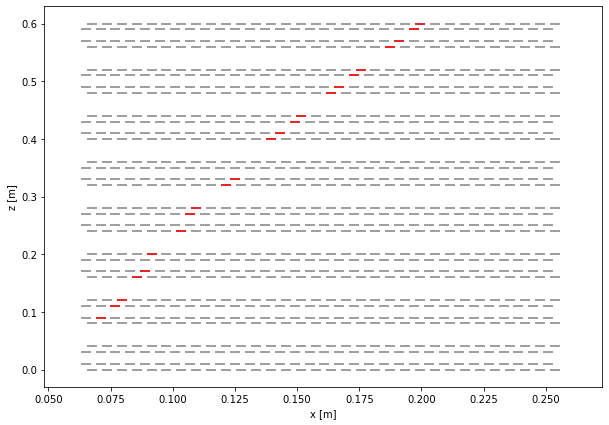

In [6]:
ev = generate_event(x_toy,z_toy,p_toy)
#ev = generate_event(-4e-2,-0.8,1.5)
#ev = generate_event(z_toy,p_toy,phi_toy)
#ev = generate_event(-0.63,2.9,0.015)
print(len(ev),ev.shape)
plot_event(ev)

In [7]:
def colorbar(mappable):
    # from https://joseph-long.com/writing/colorbars/
    #from mpl_toolkits.axes_grid1 import make_axes_locatable
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    cbar.ax.tick_params(labelsize=12)
    return cbar

def plot_1d_scan(llh_scan_res, xs, true_x, axis_label, vmax=None):
    dom_terms = np.copy(llh_scan_res)
    
    #fig, ax = plt.subplots()
    
    # subtract minimum value from each scan result
    dom_terms -= dom_terms.min()
    #if not vmax: vmax = dom_terms.max()
    
    plt.plot(xs,dom_terms,label='scan')
    plt.axvline(x=true_x,color='red',label='truth')
    #ax[0].plot([true_x], [true_y], marker='$T$', markersize=10, color='white')
    #ax[1].plot([true_x], [true_y], marker='$T$', markersize=10, color='black')
    
    plt.xlabel(axis_label)
    #plt.title(f'Log Likelihood (Gaussian)')
    plt.legend()


def plot_2d_scan(llh_scan_res, xs, ys, true_x, true_y, axis_labels, vmax=None, log=False):
    # copy to avoid modifying original scan results
    dom_terms = np.copy(llh_scan_res)
    
    if log: fig, ax = plt.subplots(1,2,figsize=(14,5)); plt.subplots_adjust(wspace=0.5)
    else: fig,ax = plt.subplots()
    gridsize = len(xs)
    
    # subtract minimum value from each scan result
    dom_terms -= dom_terms.min()
    #if not vmax: vmax = dom_terms.max()
    
    if not log: ax = [ax]
    m = ax[0].pcolormesh(xs, ys, dom_terms.reshape(gridsize, gridsize), 
                          cmap='Spectral', rasterized=True, linewidth=0, vmin=0, vmax=vmax)
    
    if log:
        mlog = ax[1].pcolormesh(xs, ys, dom_terms.reshape(gridsize, gridsize), 
                          cmap='Spectral', rasterized=True, linewidth=0, norm=colors.LogNorm(vmin=1e-3, vmax=vmax))
        
    ax[0].plot([true_x], [true_y], marker='$T$', markersize=10, color='white')
    if log: ax[1].plot([true_x], [true_y], marker='$T$', markersize=10, color='black')
    
    for axis in ax:
        axis.set_xlabel(axis_labels[0])
        axis.set_ylabel(axis_labels[1])
        #axis.set_title(f'Log Likelihood (Gaussian)')
    colorbar(m)
    if log: colorbar(mlog)

In [8]:
grid_spacing = 100

xs = np.linspace(-2e-2,2e-2,grid_spacing)

#zs = np.linspace(-1, -0.5, grid_spacing)
zs = np.linspace(-1, -0.5, grid_spacing)
#ps = np.linspace(1.5, 2.5, grid_spacing)
ps = np.linspace(1.5, 2.5, grid_spacing)
if is_full_p: ps *= 1e9/c
#phis = np.linspace(0.01, 0.06, grid_spacing)

In [9]:
N_mc = 100000#0
mc, truth = MC_events(N_mc,verbose_lvl=2)
#mc is [x,z] array

# events done: 0
# events to go: 100000
10000 events done
10000 events done
10000 events done
10000 events done
10000 events done
10000 events done
10000 events done
10000 events done
10000 events done
10000 events done
10000 events done
10000 events done
# events thrown out: 16086
# events done: 83914
# events to go: 16086
10000 events done
10000 events done
# events thrown out: 2595
# events done: 97405
# events to go: 2595
# events thrown out: 418
# events done: 99582
# events to go: 418
# events thrown out: 61
# events done: 99939
# events to go: 61
# events thrown out: 10
# events done: 99990
# events to go: 10
# events thrown out: 2
# events done: 99998
# events to go: 2
# events thrown out: 1
# events done: 99999
# events to go: 1
10000 events done
# events thrown out: 0


In [10]:
#neural nets

hitnet = types.SimpleNamespace() 

hitnet.events = mc
#n_hits_per_event = []

#for item in mc:
    #n_hits_per_event.append(item.shape[0])
    #n_hits_per_event.append(np.sum(item[:,0]>0))

#hitnet.events = np.concatenate(hitnet.events)
hitnet.events = np.asarray(mc)
print(hitnet.events.shape)
#n_hits_per_event = np.array(n_hits_per_event)
#hitnet.events = np.vstack((hitnet.events.T,np.repeat(n_hits_per_event,n_hits_per_event))).T
#hitnet.events = np.vstack((hitnet.events.T,np.repeat(n_hits_per_event,N_det))).T

#hitnet.truth = np.repeat(truth, n_hits_per_event, axis=0)
#hitnet.truth = np.repeat(truth, N_det, axis=0)
hitnet.truth = truth

assert hitnet.events.shape[0] == hitnet.truth.shape[0]

(100000, 32, 32)


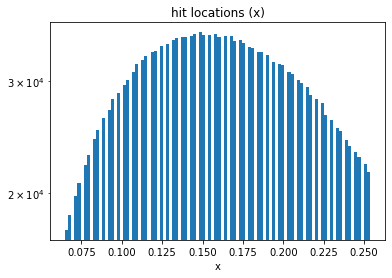

In [12]:
plt.hist(hitnet.events[:,0][hitnet.events[:,0]>0], bins=100)
plt.gca().set_yscale('log')
plt.title('hit locations (x)')
plt.xlabel('x')
plt.show()

In [11]:
def make_dataset(x, t, shuffle_block_size=2**15, batch_size=2**12):
        '''
        get a tensorflow dataset for likelihood approximation
        
        Parameters:
        -----------
        x : ndarray
            observations
        t : ndarray
            parameters        
        shuffle_block_size : int
            block size over which to shuffle, should be multiple of batch_size
        batch_size : int
        
        Returns:
        --------
        
        tf.data.Dataset
            with structure ((x, t), y) for training
        
        '''
        
        N = x.shape[0]
        assert t.shape[0] == N
        
        d_x = tf.data.Dataset.from_tensor_slices(x)
        d_t = tf.data.Dataset.from_tensor_slices(t)

        d_true_labels = tf.data.Dataset.from_tensor_slices(np.ones((N, 1), dtype=x.dtype))
        d_false_labels = tf.data.Dataset.from_tensor_slices(np.zeros((N, 1), dtype=x.dtype))

        d_xs = tf.data.Dataset.from_tensor_slices([d_x, d_x]).interleave(lambda x : x)
        d_ts = tf.data.Dataset.from_tensor_slices([d_t, d_t.shuffle(shuffle_block_size)]).interleave(lambda x : x)
        d_ys = tf.data.Dataset.from_tensor_slices([d_true_labels, d_false_labels]).interleave(lambda x : x)
        
        
        dataset = tf.data.Dataset.zip((tf.data.Dataset.zip((d_xs, d_ts)), d_ys))
  
        return dataset.batch(batch_size)



In [12]:
## charge net

hitnet.x_train, hitnet.x_test, hitnet.t_train, hitnet.t_test = train_test_split(hitnet.events, hitnet.truth, test_size=0.2, random_state=42)
hitnet.d_train = make_dataset(hitnet.x_train, hitnet.t_train)
hitnet.d_test = make_dataset(hitnet.x_test, hitnet.t_test)

In [13]:
class trafo(tf.keras.layers.Layer):

    def call(self, hits, theta):
        hits = tf.reshape(hits,[-1,N_det*N_bins])
        out = tf.concat([hits,theta],axis=1)
        return out

#class trafo(tf.keras.layers.Layer):
#    def call(self, hits, theta):
#        locs = detector_loc(N_det)
#        r2 = tf.math.square(locs - tf.reshape(theta[:,0],[-1,1])) + tf.math.square(tf.reshape(theta[:,1],[-1,1]))
#        out = tf.concat([hits,r2,theta],axis=1)
        #out = tf.concat([hits,theta],axis=1)
#        return out
    
hitnet.trafo = trafo

In [14]:
activation='relu'

x_input = tf.keras.Input(shape=(hitnet.x_train.shape[1],hitnet.x_train.shape[2]))
t_input = tf.keras.Input(shape=(hitnet.t_train.shape[1],))

h = hitnet.trafo()(x_input, t_input)

#h = tf.keras.layers.Dense(8, activation=activation)(h)

#h = tf.keras.layers.Dense(16, activation=activation)(h)
#h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(32, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(64, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(128, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(64, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(32, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

#h = tf.keras.layers.Dense(16, activation=activation)(h)
#h = tf.keras.layers.Dropout(0.01)(h)

#h = tf.keras.layers.Dense(8, activation=activation)(h)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(h)

hitnet.model = tf.keras.Model(inputs=[x_input, t_input], outputs=outputs)
hitnet.model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32)]     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
trafo (trafo)                   (None, 1027)         0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           32896       trafo[0][0]                  

In [15]:
optimizer = tf.keras.optimizers.Adam(0.001)
hitnet.model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [16]:
#n_epochs = 5
#for i in range(n_epochs):
#    hitnet.d_train = make_dataset(hitnet.x_train, hitnet.t_train)
#    hitnet.d_test = make_dataset(hitnet.x_test, hitnet.t_test)
#    hitnet.hist = hitnet.model.fit(hitnet.d_train, epochs=1, verbose=1, validation_data=hitnet.d_test)

hitnet.hist = hitnet.model.fit(hitnet.d_train, epochs=25, verbose=1, validation_data=hitnet.d_test)

Epoch 1/25
40/40 [==============================] - 4s 92ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 2/25
40/40 [==============================] - 4s 97ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 3/25
40/40 [==============================] - 4s 95ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 4/25
40/40 [==============================] - 3s 87ms/step - loss: 0.6931 - val_loss: 0.6928
Epoch 5/25
40/40 [==============================] - 4s 94ms/step - loss: 0.6921 - val_loss: 0.6820
Epoch 6/25
40/40 [==============================] - 4s 111ms/step - loss: 0.6702 - val_loss: 0.6135
Epoch 7/25
40/40 [==============================] - 3s 84ms/step - loss: 0.5762 - val_loss: 0.5487
Epoch 8/25
40/40 [==============================] - 4s 105ms/step - loss: 0.5315 - val_loss: 0.4404
Epoch 9/25
40/40 [==============================] - 4s 95ms/step - loss: 0.4461 - val_loss: 0.4017
Epoch 10/25
40/40 [==============================] - 3s 84ms/step - loss: 0.4480 - val_loss: 0.4083
Epoch 1

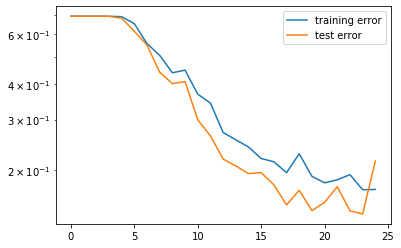

In [17]:
plt.plot(hitnet.model.history.history['loss'],label='training error')
plt.plot(hitnet.model.history.history['val_loss'],label='test error')
plt.gca().set_yscale('log')
plt.legend()
plt.show()

hitnet.llh = tf.keras.models.clone_model(hitnet.model)
hitnet.llh.set_weights(hitnet.model.get_weights())
hitnet.llh.layers[-1].activation = tf.keras.activations.linear
hitnet.llh.compile()

In [62]:
_x = stats.truncnorm(-4.5,4.5,scale=0.01).pdf(xs)
_z = stats.truncnorm(-4,4,loc=1,scale=0.25).pdf(zs)
_p = stats.truncnorm(-1.9/0.6,1.6/0.6,loc=1.9,scale=0.6).pdf(ps)

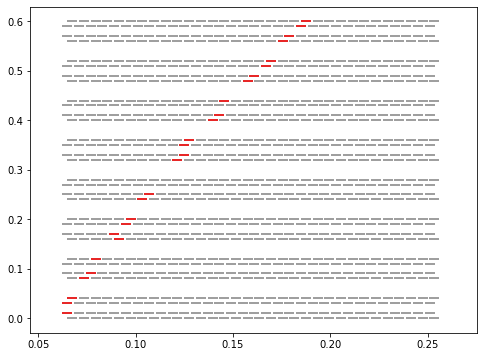

In [46]:
x_toy = np.random.uniform(-2.5e-2,2.5e-2) #should be Gaussian
z_toy = np.random.uniform(-1, -0.5) #should be Gaussian
p_toy = np.random.uniform(0.5,3.5)

ev = generate_event(x_toy,z_toy,p_toy)
plot_event(ev)

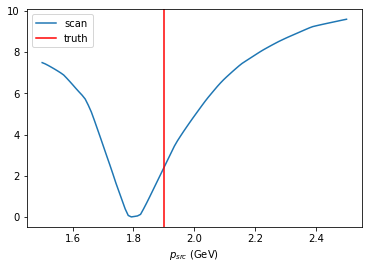

In [18]:
#len_ev = np.sum(ev[:,0]>0)

scan_t = np.array([[x_toy,z_toy]]*grid_spacing)
scan_t = np.vstack([scan_t.T,ps]).T

scan_x = np.array([ev]*grid_spacing)

nn_p_scan = hitnet.llh.predict([scan_x,scan_t])

#nn_p_scan = -np.sum(nn_p_scan.reshape(-1,len(ev)),axis=1)
plot_1d_scan(-1*nn_p_scan, ps, p_toy, axis_label='$p_{src}$ (GeV)')

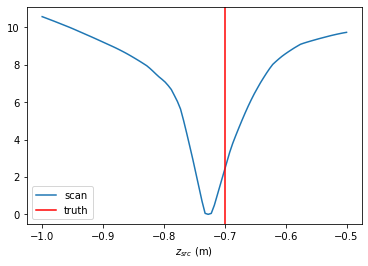

In [19]:
scan_t = np.array([[x_toy,z_toy]]*grid_spacing)
scan_t = np.vstack([np.array([x_toy]*grid_spacing),zs,np.array([p_toy]*grid_spacing)]).T

#scan_x = np.array([ev]*grid_spacing)

nn_z_scan = hitnet.llh.predict([scan_x,scan_t])

#nn_z_scan = -np.sum(nn_z_scan.reshape(-1,len(ev)),axis=1)
plot_1d_scan(-1*nn_z_scan, zs, z_toy, axis_label='$z_{src}$ (m)')

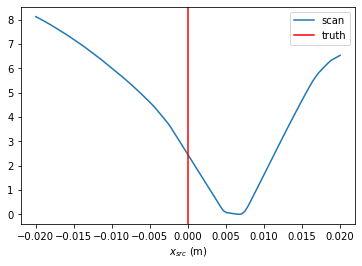

In [20]:
scan_t = np.array([[z_toy,p_toy]]*grid_spacing)
scan_t = np.vstack([xs,scan_t.T]).T

#scan_x = np.array([ev]*grid_spacing)

nn_x_scan = hitnet.llh.predict([scan_x,scan_t])

#nn_x_scan = -np.sum(nn_x_scan.reshape(-1,len(ev)),axis=1)
plot_1d_scan(-1*nn_x_scan, xs, x_toy, axis_label='$x_{src}$ (m)')

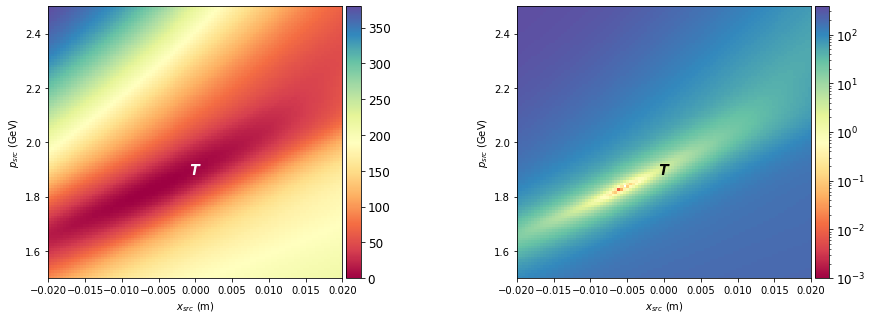

In [30]:
#change phi to x

mg = np.meshgrid(xs,ps)

hitnet.grid_t = np.vstack([mg[0].flatten(),np.ones(grid_spacing**2)*z_toy,mg[1].flatten()]).T
hitnet.grid_t = np.repeat(hitnet.grid_t,len(ev),axis=0)

hitnet.grid_x = np.tile(ev.T,grid_spacing**2)
#hitnet.grid_x = np.vstack((hitnet.grid_x,np.tile(ev[:,1],grid_spacing**2),len_ev*np.ones(grid_spacing**2*len(ev)))).T
hitnet.grid_x = np.vstack((hitnet.grid_x,len_ev*np.ones(grid_spacing**2*len(ev)))).T

hitnet.grid_llh = hitnet.llh.predict([hitnet.grid_x,hitnet.grid_t])

NN_x_p_scan = -np.sum(hitnet.grid_llh.reshape(-1, len(ev)), axis=1)
plot_2d_scan(NN_x_p_scan, xs, ps, x_toy, p_toy, 
            axis_labels=['$x_{src}$ (m)','$p_{src}$ (GeV)'],log=True)

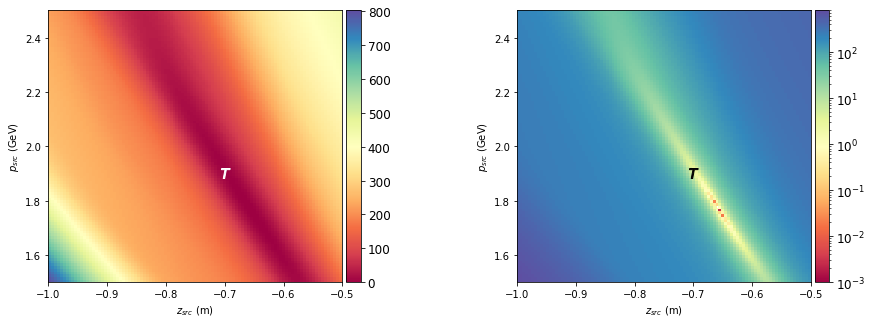

In [31]:
mg = np.meshgrid(zs,ps)

hitnet.grid_t = np.vstack([np.ones(grid_spacing**2)*x_toy,mg[0].flatten(),mg[1].flatten()]).T
hitnet.grid_t = np.repeat(hitnet.grid_t,len(ev),axis=0)

hitnet.grid_x = np.tile(ev.T,grid_spacing**2)
#hitnet.grid_x = np.vstack((hitnet.grid_x,np.tile(ev[:,1],grid_spacing**2),len_ev*np.ones(grid_spacing**2*len(ev)))).T
hitnet.grid_x = np.vstack((hitnet.grid_x,len_ev*np.ones(grid_spacing**2*len(ev)))).T

hitnet.grid_llh = hitnet.llh.predict([hitnet.grid_x,hitnet.grid_t])

NN_z_p_scan = -np.sum(hitnet.grid_llh.reshape(-1, len(ev)), axis=1)
plot_2d_scan(NN_z_p_scan, zs, ps, z_toy, p_toy, 
            axis_labels=['$z_{src}$ (m)', '$p_{src}$ (GeV)'],log=True)

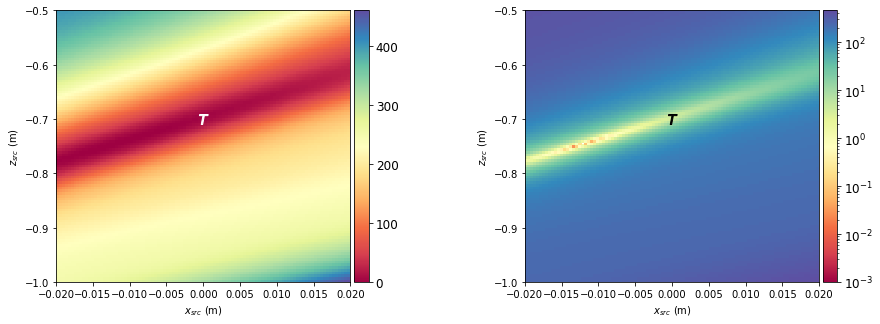

In [32]:
mg = np.meshgrid(xs,zs)

hitnet.grid_t = np.vstack([mg[0].flatten(),mg[1].flatten(),np.ones(grid_spacing**2)*p_toy]).T
hitnet.grid_t = np.repeat(hitnet.grid_t,len(ev),axis=0)

hitnet.grid_x = np.tile(ev.T,grid_spacing**2)
#hitnet.grid_x = np.vstack((hitnet.grid_x,np.tile(ev[:,1],grid_spacing**2),len_ev*np.ones(grid_spacing**2*len(ev)))).T
hitnet.grid_x = np.vstack((hitnet.grid_x,len_ev*np.ones(grid_spacing**2*len(ev)))).T

hitnet.grid_llh = hitnet.llh.predict([hitnet.grid_x,hitnet.grid_t])

NN_x_z_scan = -np.sum(hitnet.grid_llh.reshape(-1, len(ev)), axis=1)
plot_2d_scan(NN_x_z_scan, xs, zs, x_toy, z_toy, 
            axis_labels=['$x_{src}$ (m)', '$z_{src}$ (m)'],log=True)

In [53]:
def llh_fun(theta,event):
    
    event = event.reshape((1,*event.shape))
    theta = np.array(theta)
    theta = theta.reshape((1,*theta.shape))
    #params = np.tile(theta,len(event)).reshape((len(event),-1))
    #print(params) 
    #obs = np.vstack((event.T,len_ev*np.ones(len(event)))).T
    
    #pred = hitnet.llh.predict([event,params])
    #pred = hitnet.llh.predict([obs,params])
    pred = hitnet.llh.predict([event,theta])
    #print(pred)
    return -1*pred[0][0]

In [54]:
print(x_toy,z_toy,p_toy)
print(llh_fun([x_toy,z_toy,p_toy],ev))

0 -0.7 1.9
-2.985698699951172


In [55]:
opt_params = minimize(llh_fun,[2e-2,-1,2],args=(ev),method='Nelder-Mead',options={'maxiter':100000,'disp':True})

print(opt_params)

 final_simplex: (array([[-1.78748676e+36, -9.39538267e+37,  3.40282335e+38],
       [-1.78748676e+36, -9.39538267e+37,  3.40282335e+38],
       [-1.78748676e+36, -9.39538267e+37,  3.40282335e+38],
       [-1.78748676e+36, -9.39538267e+37,  3.40282335e+38]]), array([-6.27710864e+37, -6.27710864e+37, -6.27710864e+37, -6.27710864e+37]))
           fun: -6.2771086350294985e+37
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 499019
           nit: 100000
        status: 2
       success: False
             x: array([-1.78748676e+36, -9.39538267e+37,  3.40282335e+38])


In [57]:
lims = Bounds([-2.5e-2,-1,0.5],[2.5e-2,-0.5,3.5],keep_feasible=True)#
opt_params = minimize(llh_fun,[2e-2,-1,2],args=(ev),method='Powell',bounds=[(-2.5e-2,2.5e-2),(-1,-0.5),(0.5,3.5)],options={'maxiter':100000,'disp':True,'return_all':False})

print(opt_params)

Optimization terminated successfully.
         Current function value: -3.217672
         Iterations: 9
         Function evaluations: 728
   direc: array([[ 1.59362945e-03, -8.84128546e-03,  6.99520385e-02],
       [ 4.91792619e-03, -1.97956614e-02,  1.56683158e-01],
       [-1.32149376e-06,  6.36888790e-06, -4.77322515e-05]])
     fun: -3.2176718711853027
 message: 'Optimization terminated successfully.'
    nfev: 728
     nit: 9
  status: 0
 success: True
       x: array([ 0.01111221, -0.99999991,  3.25081525])


In [144]:
opt_params = minimize(llh_fun,[0,-0.5,2],args=(ev),method='Nelder-Mead',options={'maxiter':100000,'disp':True})

print(opt_params)

Optimization terminated successfully.
         Current function value: -86.071060
         Iterations: 140
         Function evaluations: 246
 final_simplex: (array([[-0.03400283, -0.9312827 ,  2.24420036],
       [-0.03400261, -0.9312898 ,  2.24421586],
       [-0.03399327, -0.93121943,  2.24410697],
       [-0.03400369, -0.93130042,  2.24424069]]), array([-86.07106018, -86.07102966, -86.07102203, -86.07099915]))
           fun: -86.07106018066406
       message: 'Optimization terminated successfully.'
          nfev: 246
           nit: 140
        status: 0
       success: True
             x: array([-0.03400283, -0.9312827 ,  2.24420036])


In [61]:
opt_params = minimize(llh_fun,[0,-0.5,2],args=(ev),method='Powell',bounds=[(-2.5e-2,2.5e-2),(-1,-0.5),(0.5,3.5)],options={'maxiter':100000,'disp':True})

print(opt_params)

Optimization terminated successfully.
         Current function value: -3.045342
         Iterations: 2
         Function evaluations: 88
   direc: array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])
     fun: -3.045341968536377
 message: 'Optimization terminated successfully.'
    nfev: 88
     nit: 2
  status: 0
 success: True
       x: array([ 0.02493329, -0.61913174,  2.00004187])


In [62]:
#test if result from minimizer gives same event?
test_ev = generate_event(*opt_params.x)
#print(ev)
#print(len(test_ev))
#print(test_ev)
print(ev-test_ev)

[[-8.34112447e-04  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -5.75211761e-05 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


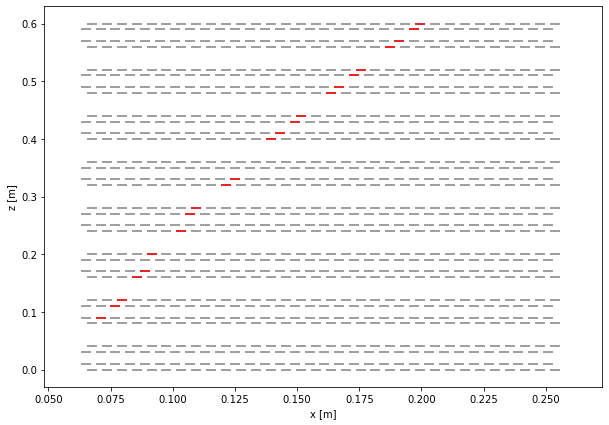

In [59]:
plot_event(ev)

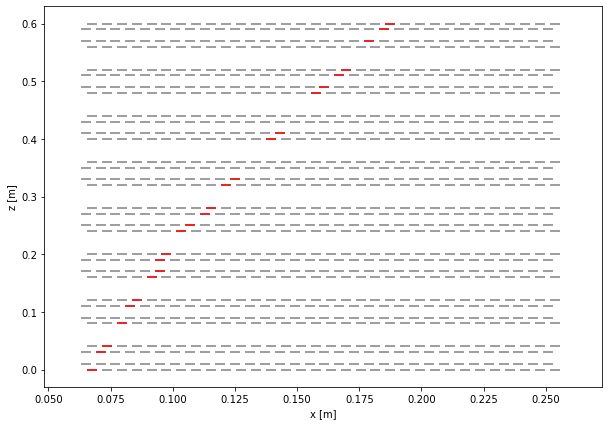

In [63]:
plot_event(test_ev)